## This Notebook shows the data modelling process on the cleaned data

In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc, classification_report

In [ ]:
#reading the data
data  = pd.read_csv("/content/drive/MyDrive/Data Science /Data/Cleaned_Consumer_Complaints.csv")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593746 entries, 0 to 593745
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       593746 non-null  object
 1   Issue                         593746 non-null  object
 2   Company                       593746 non-null  object
 3   State                         593746 non-null  object
 4   ZIP_code                      593746 non-null  object
 5   Consumer_consent_provided?    593746 non-null  object
 6   Submitted_via                 593746 non-null  object
 7   Date_sent_to_company          593746 non-null  object
 8   Company_response_to_consumer  593746 non-null  object
 9   Timely_response?              593746 non-null  object
 10  Consumer_disputed?            593746 non-null  object
dtypes: object(11)
memory usage: 49.8+ MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

,Product,Issue,Company,State,ZIP_code,Consumer_consent_provided?,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response?,Consumer_disputed?
0,Credit reporting,Incorrect information on credit report,EXPERIAN DELAWARE GP,TX,77075,Consent provided,Phone,03/21/2017,Closed with non-monetary relief,Yes,No
1,Debt collection,Disclosure verification of debt,"Security Credit Services, LLC",IL,60643,Consent provided,Web,04/20/2017,Closed with explanation,Yes,No
2,Credit card,Other,"CITIBANK, N.A.",IL,62025,Consent provided,Referral,04/20/2017,Closed with explanation,Yes,No
3,Mortgage,"Loan modification,collection,foreclosure","Shellpoint Partners, LLC",CA,90305,Consent provided,Referral,04/14/2017,Closed with explanation,Yes,No
4,Credit card,Credit determination,U.S. BANCORP,LA,70571,Consent provided,Postal mail,04/21/2017,Closed with explanation,Yes,No


### Data Preparation

##### Feature Engineering

In [ ]:
df['Date_sent_to_company'] = pd.to_datetime(df['Date_sent_to_company'])
df['Year'] = df['Date_sent_to_company'].dt.year

In [ ]:
#encoding
df['Consumer_disputed?'] = df['Consumer_disputed?'].replace({"Yes": 1, "No": 0})
df['Timely_response?'] = df['Timely_response?'].replace({"Yes": 1, "No": 0})

#dropping columns
df.drop(columns=["ZIP_code", "Date_sent_to_company", "Company", "State"], inplace=True)

In [ ]:
categorical = [col for col in df.columns if df[col].dtype != 'int64']
numerical = [col for col in df.columns if df[col].dtype == 'int64']
numerical.remove("Consumer_disputed?")


#### Splitting the data


In [ ]:
features, target = (df[categorical + numerical], df['Consumer_disputed?'])
df_full_train, df_test, y_full_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=42)

#  = df_full_train['Consumer_disputed?'].values
# y_train = df_train['Consumer_disputed?'].values

# y_test = df_test['Consumer_disputed?'].values

### Visualizing Target Variable

[Text(0.5, 0, 'Consumer_disputed?'),
 Text(0.5, 1.0, 'Distribution of Consumer Disputed')]

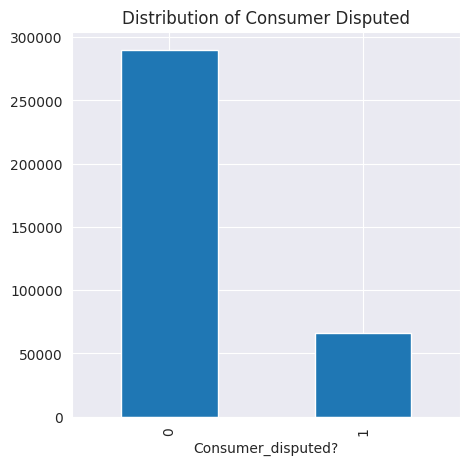

In [ ]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
ax = y_train.value_counts().plot(kind="bar")
ax.set(xlabel="Consumer_disputed?", title="Distribution of Consumer Disputed")

### Handling Class Imbalance

In [ ]:
#instantiating a class of random oversampler
oversampler = RandomOverSampler(random_state=1)

#creating oversampled training and testing sets
df_train, y_train = oversampler.fit_resample(df_train, y_train)

df_val, y_val = oversampler.fit_resample(df_val, y_val)

In [ ]:
# from collections import Counter
# print(f"Target variable before resampling: {Counter(y_train)}")
# print(f"Target variable after resampling: {Counter(y_train_over)}")

[Text(0.5, 0, 'Consumer_disputed?'),
 Text(0.5, 1.0, 'Distribution of Consumer Disputed After Sampling')]

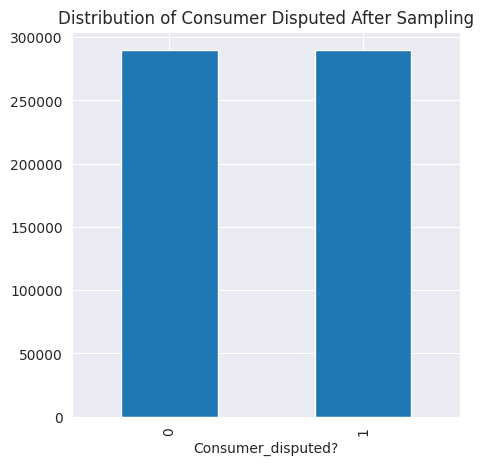

In [ ]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
ax = y_train.value_counts().plot(kind="bar")
ax.set(xlabel="Consumer_disputed?", title="Distribution of Consumer Disputed After Sampling")

In [ ]:
def chi_square_test(series):
  """
  This function computes the p-value from the
  contingency table of two variables
  params: pandas series
  returns: p-value
  rtype: float
  """
  table = pd.crosstab(y_train, series)
  stats, p_val, dof, expected_table = chi2_contingency(table)
  return p_val

In [ ]:
def corr(series):
  """
  This function calculates the correlation value between two columns
  params: pandas series
  returns: correlation value
  rtype: float
  """
  return y_train.corr(series)

In [ ]:
def calculate_mi(series):
  """
  This function calculates the mutual info score between the target column and a specified categorical column
  params: categorical column
  returns: mutual info score
  rtype: float
  """
  mi = mutual_info_score(y_train, series)
  return mi

In [ ]:
#chi square test on categorical columns
df_train[categorical].apply(calculate_mi)

Product                         0.005120
Issue                           0.009195
Consumer_consent_provided?      0.000037
Submitted_via                   0.004015
Company_response_to_consumer    0.012175
dtype: float64

In [ ]:
df_train[categorical].apply(chi_square_test).sort_values(ascending=False)

Consumer_consent_provided?      2.695282e-09
Product                         0.000000e+00
Issue                           0.000000e+00
Submitted_via                   0.000000e+00
Company_response_to_consumer    0.000000e+00
dtype: float64

In [ ]:
#correlation test on numerical columns
df_train[numerical].apply(corr)

Timely_response?    0.040934
Year               -0.095872
dtype: float64

In [ ]:
#Transforming Data splits with one hot encoding
train_dict = df_train.to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

#### Random Forest

In [ ]:
#creating an instance of the random forest classifier
rf = RandomForestClassifier(random_state=11)

#fitting model to data
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

#Evaluating the random forest model
print(f" The validation auc is {roc_auc_score(y_val, y_pred_rf)}")

 The validation auc is 0.5878110275274862


In [ ]:
#classification report
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55     96776
           1       0.57      0.68      0.62     96776

    accuracy                           0.59    193552
   macro avg       0.59      0.59      0.58    193552
weighted avg       0.59      0.59      0.58    193552



In [ ]:
print(df_train[categorical].apply(calculate_mi).sort_values(ascending=False))
# df_train.dtypes

Company_response_to_consumer    0.012175
Issue                           0.009195
Product                         0.005120
Submitted_via                   0.004015
Consumer_consent_provided?      0.000037
dtype: float64


In [ ]:
cat_columns = ['Company_response_to_consumer', 'Issue', 'Product', 'Submitted_via', 'Consumer_consent_provided?']
columns = cat_columns + numerical

#### Backward Selection

In [ ]:
for col in columns:
  cols = columns.copy()
  cols.remove(col)
  train_dict = df_train[cols].to_dict(orient='records')
  dv = DictVectorizer()
  X_train = dv.fit_transform(train_dict)
  val_dict = df_val[cols].to_dict(orient='records')
  X_val = dv.transform(val_dict)

  rf = RandomForestClassifier(random_state=11)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_val)
  score = roc_auc_score(y_val, y_pred_rf)
  print(f"omitted column:{col} auc_score:{score}")

omitted column:Company_response_to_consumer auc_score:0.5715663556479644
omitted column:Issue auc_score:0.5899592219656985
omitted column:Product auc_score:0.5875880222923532
omitted column:Submitted_via auc_score:0.579080072648547
omitted column:Consumer_consent_provided? auc_score:0.5908094990973933
omitted column:Timely_response? auc_score:0.5852336950342248
omitted column:Year auc_score:0.5845048952007845


In [ ]:
new_cols = []
for col in columns:
  new_cols.append(col)
  train_dict = df_train[new_cols].to_dict(orient='records')
  dv = DictVectorizer()
  X_train = dv.fit_transform(train_dict)
  val_dict = df_val[new_cols].to_dict(orient='records')
  X_val = dv.transform(val_dict)

  rf = RandomForestClassifier(random_state=11)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_val)
  score = roc_auc_score(y_val, y_pred_rf)
  print(f"columns trained on:{new_cols} auc_score:{score}")


columns trained on:['Company_response_to_consumer'] auc_score:0.5527929658958567
columns trained on:['Company_response_to_consumer', 'Issue'] auc_score:0.5732353729767196
columns trained on:['Company_response_to_consumer', 'Issue', 'Product'] auc_score:0.574432222971265
columns trained on:['Company_response_to_consumer', 'Issue', 'Product', 'Submitted_via'] auc_score:0.5833998605177935
columns trained on:['Company_response_to_consumer', 'Issue', 'Product', 'Submitted_via', 'Consumer_consent_provided?'] auc_score:0.5830620449362165
columns trained on:['Company_response_to_consumer', 'Issue', 'Product', 'Submitted_via', 'Consumer_consent_provided?', 'Timely_response?'] auc_score:0.5845048952007845
columns trained on:['Company_response_to_consumer', 'Issue', 'Product', 'Submitted_via', 'Consumer_consent_provided?', 'Timely_response?', 'Year'] auc_score:0.5868953675236731


In [ ]:
#Tuning random forests
scores = []
for i in range(10, 201, 10):
  rf = RandomForestClassifier(n_estimators = i, random_state=11)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_val)
  auc = roc_auc_score(y_val, y_pred_rf)
  print('%s -> %.3f' % (i, auc))
  scores.append(auc)




10 -> 0.586
20 -> 0.586
30 -> 0.586
40 -> 0.586
50 -> 0.587
60 -> 0.587
70 -> 0.587
80 -> 0.587
90 -> 0.587
100 -> 0.587
110 -> 0.587
120 -> 0.587
130 -> 0.587
140 -> 0.587
150 -> 0.587
160 -> 0.587
170 -> 0.587
180 -> 0.587
190 -> 0.587
200 -> 0.587


In [ ]:
#Tuning random forests
depths = [5, 10, 20]
for d in depths:
  print(f"depth: {d}")
  for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators = i, max_depth = d, random_state=11)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred_rf)
    print('%s -> %.3f' % (i, auc))
    # scores.append(auc)




depth: 5
10 -> 0.582
20 -> 0.588
30 -> 0.589
40 -> 0.590
50 -> 0.589
60 -> 0.590
70 -> 0.589
80 -> 0.590
90 -> 0.590
100 -> 0.589
110 -> 0.590
120 -> 0.590
130 -> 0.590
140 -> 0.590
150 -> 0.590
160 -> 0.590
170 -> 0.590
180 -> 0.589
190 -> 0.588
200 -> 0.589
depth: 10
10 -> 0.594
20 -> 0.594
30 -> 0.593
40 -> 0.594
50 -> 0.594
60 -> 0.595
70 -> 0.594
80 -> 0.595
90 -> 0.595
100 -> 0.595
110 -> 0.595
120 -> 0.595
130 -> 0.595
140 -> 0.595
150 -> 0.595
160 -> 0.595
170 -> 0.595
180 -> 0.595
190 -> 0.595
200 -> 0.595
depth: 20
10 -> 0.592
20 -> 0.593
30 -> 0.593
40 -> 0.593
50 -> 0.594
60 -> 0.593
70 -> 0.593
80 -> 0.593
90 -> 0.593
100 -> 0.593
110 -> 0.593
120 -> 0.593
130 -> 0.593
140 -> 0.594
150 -> 0.594
160 -> 0.594
170 -> 0.594
180 -> 0.594
190 -> 0.594
200 -> 0.594


[Text(0.5, 25.722222222222214, 'Predicted Values'),
 Text(33.22222222222222, 0.5, 'Actual Values'),
 Text(0.5, 1.0, 'RAndom Forest Confusion Matrix')]

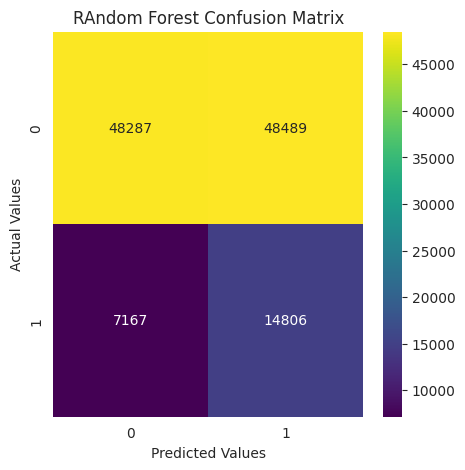

In [ ]:
#Confusion Matrix
plt.figure(figsize = (5,5))
cm_rf = confusion_matrix(y_val, y_pred_rf)
ax = sns.heatmap(cm_rf, annot=True, fmt="d", cmap="viridis")
ax.set(xlabel="Predicted Values", ylabel="Actual Values", title="RAndom Forest Confusion Matrix")

### XGBoost

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names= dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names= dv.feature_names_)

['Product',
 'Issue',
 'Consumer_consent_provided?',
 'Submitted_via',
 'Company_response_to_consumer']

In [ ]:
#instantiating model
xgb_clf = xgb.XGBClassifier(booster="gbtree", random_state=11)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_val)

roc_auc_score(y_val, y_pred_xgb)

NameError: ignored

In [ ]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

In [ ]:
xgb_clf = xgb.train(xgb_params, dtrain)
y_pred_xgb = xgb_clf.predict(dval)
roc_auc_score(y_val, y_pred_xgb)


0.6319018215807005

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500,
                  evals=watchlist, verbose_eval=10)


[0]	train-auc:0.63615	val-auc:0.62564
[10]	train-auc:0.64822	val-auc:0.63164
[20]	train-auc:0.65311	val-auc:0.63195
[30]	train-auc:0.65603	val-auc:0.63149
[40]	train-auc:0.65836	val-auc:0.63109
[50]	train-auc:0.66139	val-auc:0.63027
[60]	train-auc:0.66278	val-auc:0.62975
[70]	train-auc:0.66385	val-auc:0.62929
[80]	train-auc:0.66499	val-auc:0.62896
[90]	train-auc:0.66641	val-auc:0.62835
[100]	train-auc:0.66739	val-auc:0.62783
[110]	train-auc:0.66856	val-auc:0.62715
[120]	train-auc:0.66933	val-auc:0.62679
[130]	train-auc:0.67007	val-auc:0.62658
[140]	train-auc:0.67081	val-auc:0.62609
[150]	train-auc:0.67107	val-auc:0.62576
[160]	train-auc:0.67147	val-auc:0.62548
[170]	train-auc:0.67188	val-auc:0.62535
[180]	train-auc:0.67274	val-auc:0.62504
[190]	train-auc:0.67318	val-auc:0.62455
[200]	train-auc:0.67349	val-auc:0.62438
[210]	train-auc:0.67365	val-auc:0.62421
[220]	train-auc:0.67387	val-auc:0.62403
[230]	train-auc:0.67427	val-auc:0.62370
[240]	train-auc:0.67452	val-auc:0.62357
[250]	train

In [ ]:
for col in columns:
  cols = columns.copy()
  cols.remove(col)
  train_dict = df_train[cols].to_dict(orient='records')
  dv = DictVectorizer()
  X_train = dv.fit_transform(train_dict)
  val_dict = df_val[cols].to_dict(orient='records')
  X_val = dv.transform(val_dict)

  dtrain = xgb.DMatrix(X_train, label=y_train, feature_names= dv.feature_names_)
  dval = xgb.DMatrix(X_val, label=y_val, feature_names= dv.feature_names_)

  xgb_clf = xgb.train(xgb_params, dtrain, num_boost_round=500)
  y_pred_xgb = xgb_clf.predict(dval)
  score = roc_auc_score(y_val, y_pred_xgb)
  print(f"omitted column:{col} auc_score:{score}")


omitted column:Product auc_score:0.6227603469464981
omitted column:Issue auc_score:0.6209539498265475
omitted column:Consumer_consent_provided? auc_score:0.6257742831923091
omitted column:Submitted_via auc_score:0.6097919953923326
omitted column:Company_response_to_consumer auc_score:0.601852468404555
omitted column:Timely_response? auc_score:0.6204447392207668
omitted column:Year auc_score:0.6173129420172121


In [ ]:
cols = columns.copy()
new_cols = []
for col in cols:
  new_cols.append(col)
  train_dict = df_train[new_cols].to_dict(orient='records')
  dv = DictVectorizer()
  X_train = dv.fit_transform(train_dict)
  val_dict = df_val[new_cols].to_dict(orient='records')
  X_val = dv.transform(val_dict)

  dtrain = xgb.DMatrix(X_train, label=y_train, feature_names= dv.feature_names_)
  dval = xgb.DMatrix(X_val, label=y_val, feature_names= dv.feature_names_)

  xgb_clf = xgb.train(xgb_params, dtrain, num_boost_round=500)
  y_pred_xgb = xgb_clf.predict(dval)
  score = roc_auc_score(y_val, y_pred_xgb)

  print(f"columns trained on:{new_cols} auc_score:{score}")


columns trained on:['Product'] auc_score:0.5555742421238484
columns trained on:['Product', 'Issue'] auc_score:0.5725858843344157
columns trained on:['Product', 'Issue', 'Consumer_consent_provided?'] auc_score:0.5720150452199069
columns trained on:['Product', 'Issue', 'Consumer_consent_provided?', 'Submitted_via'] auc_score:0.5918692921379034
columns trained on:['Product', 'Issue', 'Consumer_consent_provided?', 'Submitted_via', 'Company_response_to_consumer'] auc_score:0.6154812606106677
columns trained on:['Product', 'Issue', 'Consumer_consent_provided?', 'Submitted_via', 'Company_response_to_consumer', 'Timely_response?'] auc_score:0.6173129420172121
columns trained on:['Product', 'Issue', 'Consumer_consent_provided?', 'Submitted_via', 'Company_response_to_consumer', 'Timely_response?', 'Year'] auc_score:0.6213920720658994


### Logistic Regression

In [ ]:
for c in [1, 0.1, 0.01, 0.001]:
  lr = LogisticRegression(C=c, solver='saga', max_iter=1000)
  lr.fit(X_train, y_train)
  y_pred_lr = lr.predict(X_val)
  lr_score = roc_auc_score(y_val, y_pred_lr)
  print(c, lr_score)
  print()

1 0.584085930395966

0.1 0.5841014301066381

0.01 0.5839567661403655

0.001 0.5846645862610566



### GridSearchCV


#### Random Forests

In [ ]:
#creating an instance of the random forest classifier
rf = RandomForestClassifier()

#specifying parameters for GridSearchCV
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [1, 3, 5, 7, 9],
    'min_samples_split': [5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9],
    'bootstrap': [True, False],
    'max_features':[2, 3, 4, 5,]
}

#creating a GridSearchCV Instance with specified parameters
rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=4)

#training the model
rf_grid.fit(X_train, y_train)

#best combination of parameters
print(rf_grid.best_params_)

#best score
print(rf_grid.best_score_)



###XGBoost


In [ ]:
 # #instantiating model
xgb_clf = xgb.XGBClassifier(booster="gbtree", random_state=11)

xgb_params = {
    'n_estimators': [10, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
}

xgb_grid = GridSearchCV(xgb_clf, xgb_params, scoring='roc_auc', cv=4)

xgb_grid.fit(X_train, y_train)


#best combination of parameters
print(xgb_grid.best_params_)

#best score
print(xgb_grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
0.6505904956858395


Final Model

In [ ]:
#storing features in a dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names= dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names= dv.feature_names_)

#specifying parameters
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 9
}

xgb_clf = xgb.train(xgb_params, dtrain)

y_pred_xgb = xgb_clf.predict(dval)

score = roc_auc_score(y_val, y_pred_xgb)

print(score)

[11:44:28] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

0.6307532758720293
